# 5b. Create DBSCAN Clustered Input Data

Used the DBSCAN function from DBSCAN exploration to get the image segmentation. Otherwise, it is the same method as creating the K-means cluster masks from step 4b.

## Setup 

In [1]:
import cv2
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
#import rasterio
import shapely.geometry

import re

import matplotlib.pyplot as plt
import os
import re
from scipy.misc import imresize

from sklearn.cluster import DBSCAN
from collections import OrderedDict, Counter
import scipy.ndimage as ndimage

%matplotlib inline

## Helper Functions 

In [2]:
def resize(img, new_shape):
    img_resized = np.zeros(new_shape+(img.shape[2],)).astype('float32')
    for i in range(img.shape[2]):
        img_resized[:, :, i] = imresize(img[:, :, i], new_shape, interp='bicubic')
    return img_resized

def scale_bands(img, lower_pct = 1, upper_pct = 99):
    """
    Rescale the bands of a multichannel image for display
    """
    # Loop through the image bands, rescaling each one
    img_scaled = np.zeros(img.shape, np.uint8)
    
    for i in range(img.shape[2]):
        
        band = img[:, :, i]
        
        # Pick out the lower and upper percentiles
        lower, upper = np.percentile(band, [lower_pct, upper_pct])
        
        # Normalize the band
        band = (band - lower) / (upper - lower) * 255
        
        # Clip the high and low values, and cast to uint8
        img_scaled[:, :, i] = np.clip(band, 0, 255).astype(np.uint8)
        
    return img_scaled

from sklearn.metrics import jaccard_similarity_score
# Function to create an iterator with examples
smooth=1
def jacc_coef_int(y_true, y_pred):
    y_pred_pos = y_pred
    intersection = np.sum(y_true * y_pred_pos)
    sum_ = np.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return np.mean(jac)

def dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

## Main function 

In [3]:
def dbscan_train(img, epsilon=1.25, minpts=85):
    Z = img.reshape((-1,3))
    Z = np.float32(Z)
    db = DBSCAN(eps=epsilon,min_samples=minpts,n_jobs=-1).fit(Z)
    return db
def dbscan_mask(img, db, count1=0, count2=0):
    #Number of Clusters 
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    dimension = int(img.shape[0])
    #Reshping labels into mask of clusters (feature map)
    mask_clustered = np.reshape(labels, (dimension,dimension))
    
    #If there is only one cluster, try a different parameter
    if n_clusters_ == 1 and count1 ==0 and count2 == 0:
        count1+=1
        return dbscan_mask(img,dbscan_train(img, 1.75, 85),count1)
    elif n_clusters_ == 1 and count1 == 1 and count2 == 0:
        count1+=1
        return dbscan_mask(img,dbscan_train(img, 1.5, 85),count1)
    elif n_clusters_ == 1 and count1 > 1 and count2 == 0:
        return np.zeros((dimension,dimension)), mask_clustered, n_clusters_
    
    else:
        #Ranking the most common clusters
        most_common_clusters = Counter(mask_clustered.flatten()).most_common()
        cluster_map = OrderedDict((k, v) for k, v in most_common_clusters if k >= 0) #gets cluster index, AND throws out the negative-1 group

        #Filtering out clusters that are too white, black, or green.
        #Initialization
        new_mask = np.zeros((dimension,dimension))
        for index in cluster_map.keys():
            if len(cluster_map.keys()) == 0:
                break

            #Expanding dimension of a cluster mask and counting the pixels for the RGB channels.
            rgb_sum = (img * np.expand_dims(mask_clustered == index, axis = 2)).sum(axis=(0,1))

            #If cluster is too white or black
            if float(rgb_sum.std())/rgb_sum.mean() < 0.11:
                #print("Too white or black",index,count1,count2)
                continue

            #If cluster is too green
            if float(rgb_sum[1])/rgb_sum[0] > 1.1 :
                #print("Too much vegatation",index,count1,count2)
                continue

            else:
                new_mask = 255 * (mask_clustered==index)
                #print("Not filtered: ",index,count1,count2,db)
                break

        #If the mask are blank, try a different parameter
        if new_mask.sum() == 0 and count2==0:
            count2+=1
            #print("No mask and count: ",count2)
            return dbscan_mask(img,dbscan_train(img, 1.75, 85),count2=count2)
            
        elif new_mask.sum() == 0 and count2==1:
            count2+=1
            #print("No mask and count: ",count2)
            return dbscan_mask(img,dbscan_train(img, 1.5, 85),count2=count2)
            
        elif new_mask.sum() == 0 and count2 > 1:
            new_mask = np.zeros((dimension,dimension))
            #print("No mask and count: ",count2,db)
            
    return new_mask, mask_clustered, n_clusters_
    

In [4]:
def make_files(files, input_size):
    num = 0
    for tile_no in files:
        #Loading and resizing Image
        img = np.load(tile_no + '_img.npy') 
        img = imresize(img, (input_size, input_size))
        
        #Calling main function
        new_mask,_,_ = dbscan_mask(img ,dbscan_train(img, 1.25, 85))
        
        #Discard masks with no pixels
        if new_mask.sum() == 0 :
            continue
        else:   
            #Make file
            np.save("training_tiles_DBSCANv2/%d_mask"%num, new_mask)
            np.save("training_tiles_DBSCANv2/%d_img"%num, img)
            num += 1


## Generating Masks 

In [5]:
input_size = 256

dir_path = 'training_tiles_1000size/'
np_files = [os.path.join(path,f[:f.find('_img.npy')])
             for path,_,files in os.walk(dir_path) 
             for f in files if (f.endswith('img.npy'))]

if not os.path.exists('training_tiles_DBSCANv2'):
    os.makedirs('training_tiles_DBSCANv2')


make_files(np_files, input_size)

/home/mlt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


0.0

## Visualizing the image and mask 

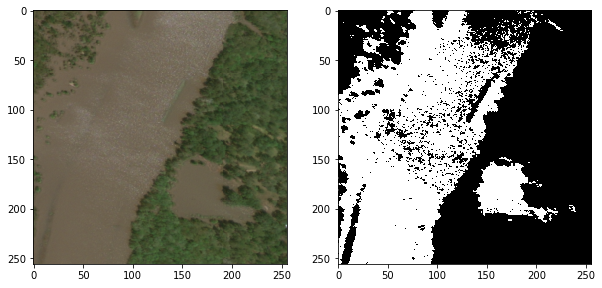

In [10]:
import matplotlib.pyplot as plt## Visualizing the image and mask 
import numpy as np
%matplotlib inline

dir_path = 'training_tiles_DBSCANv2/'
np_files = [os.path.join(path,f[:f.find('_img.npy')])
             for path,_,files in os.walk(dir_path) 
             for f in files if (f.endswith('img.npy'))]

tile = np.random.choice(np_files,replace=False)

img = np.load(tile+'_img.npy')
mask = np.load(tile+'_mask.npy')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
ax1.imshow(img)
ax2.imshow(mask,cmap=plt.cm.gray)

